In [1]:
import os
import sys
import time
import glob
import shutil
import datetime
import subprocess

import cv2
import numpy as np
from PIL import Image
from ipywidgets import Video
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
sys.path.append('..')
from nsds.common import Params
from modules.utils import get_image_from_url, build_video_from_images, distance, load_json
from modules.face_model import FaceModelWrapper, get_center_bbox, crop_face_and_pad
from modules.face_tracking import SimpleFaceTracking
from modules.visualize_detection import visualize_face_detection, visualize_face_align, \
    visualize_face_recognition, draw_person_info, build_demo_video

params = Params.from_file('../config/streaming.json')
params['detector']['prefix'] = os.path.join('..', params['detector']['prefix'])
params['featurizer']['prefix'] = os.path.join('..', params['featurizer']['prefix'])
params['vector_search']['data_file'] = os.path.join('..', params['vector_search']['data_file'])
model = FaceModelWrapper(params)
tracker = SimpleFaceTracking(n_cached=15, moving_threshold=80)
metadata = load_json(os.path.join('..', params.pop('metadata')))

loading  ../modules/pretrain_models/arcface/model-r50-am-lfw/model


32it [00:00, 2468.92it/s]


In [3]:
# Warm up
video_src = '/media/disk2/thanhtc/o2o/data/debug/demo.mp4'
build_demo_video(video_src, model, tracker, metadata)

Time: 121.15828895568848 - Num frames: 1136 - Fps: 9.376163625864098


In [ ]:
# video_src = '/media/disk2/thanhtc/o2o/data/debug/demo.mp4'
# video_dir, video_file = os.path.split(video_src)
# video_name = os.path.splitext(video_file)[0]

# tmp_dir = '/media/disk2/thanhtc/o2o/data/debug/tmp'
# if os.path.exists(tmp_dir):
#     shutil.rmtree(tmp_dir)
# os.makedirs(tmp_dir)

# video_capture = cv2.VideoCapture(video_src)
# n_frames = 0
# max_frames = -1

# while True:
#     if video_capture.isOpened():
#         status, frame = video_capture.read()
#         if frame is not None:
#             n_frames += 1
#             if n_frames % 4 == 0:
#                 bboxs, _ = model.detect_face(frame)
#                 for i, box in enumerate(bboxs):
#                     face, _ = crop_face_and_pad(frame, box, 30)
#                     cv2.imwrite(os.path.join(tmp_dir, f'img{n_frames}_{i + 1}.jpg'), face)
#             # frame = visualize_face_recognition(model, frame, metadata=metadata)
            
#             # cv2.imwrite(os.path.join(tmp_dir, f'img{n_frames}.png'), frame)
#         if not status or (max_frames > 0 and n_frames >= max_frames):
#             break

In [4]:
face_detection_video = Video.from_file(output_video)
face_detection_video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00g8\xd7mdat\x00\x00\…

In [ ]:
img_path_1 = '/media/disk2/thanhtc/o2o/data/debug/yena.jpg'
img_path_2 = '/media/disk2/thanhtc/o2o/data/debug/yuri.jpg'
img_1 = cv2.imread(img_path_1)
align_img_1_viz = visualize_face_align(model, img_1)
img_2 = cv2.imread(img_path_2)
align_img_2_viz = visualize_face_align(model, img_2)

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(2, 1, 1)
ax.imshow(align_img_1_viz[:, :, ::-1])
ax = fig.add_subplot(2, 1, 2)
ax.imshow(align_img_2_viz[:, :, ::-1])
plt.show()

In [ ]:
s = time.time()
_, _, embs_1 = model.detect_and_extract_embedding(img_1)
print(time.time() - s)

s = time.time()
_, _, embs_2 = model.detect_and_extract_embedding(img_2)
print(time.time() - s)

distance(embs_1, embs_2)  # 1.1675067

In [ ]:
url = 'https://image.insider.com/5da6e0c9045a3132b57ef404?width=1100&format=jpeg&auto=webp'

img = get_image_from_url(url)
img = img[:, :, ::-1]
img = cv2.resize(img, (640, 480))

detection_img = visualize_face_recognition(model, img)

display(Image.fromarray(detection_img[:, :, ::-1]))

['3', '1', '3']


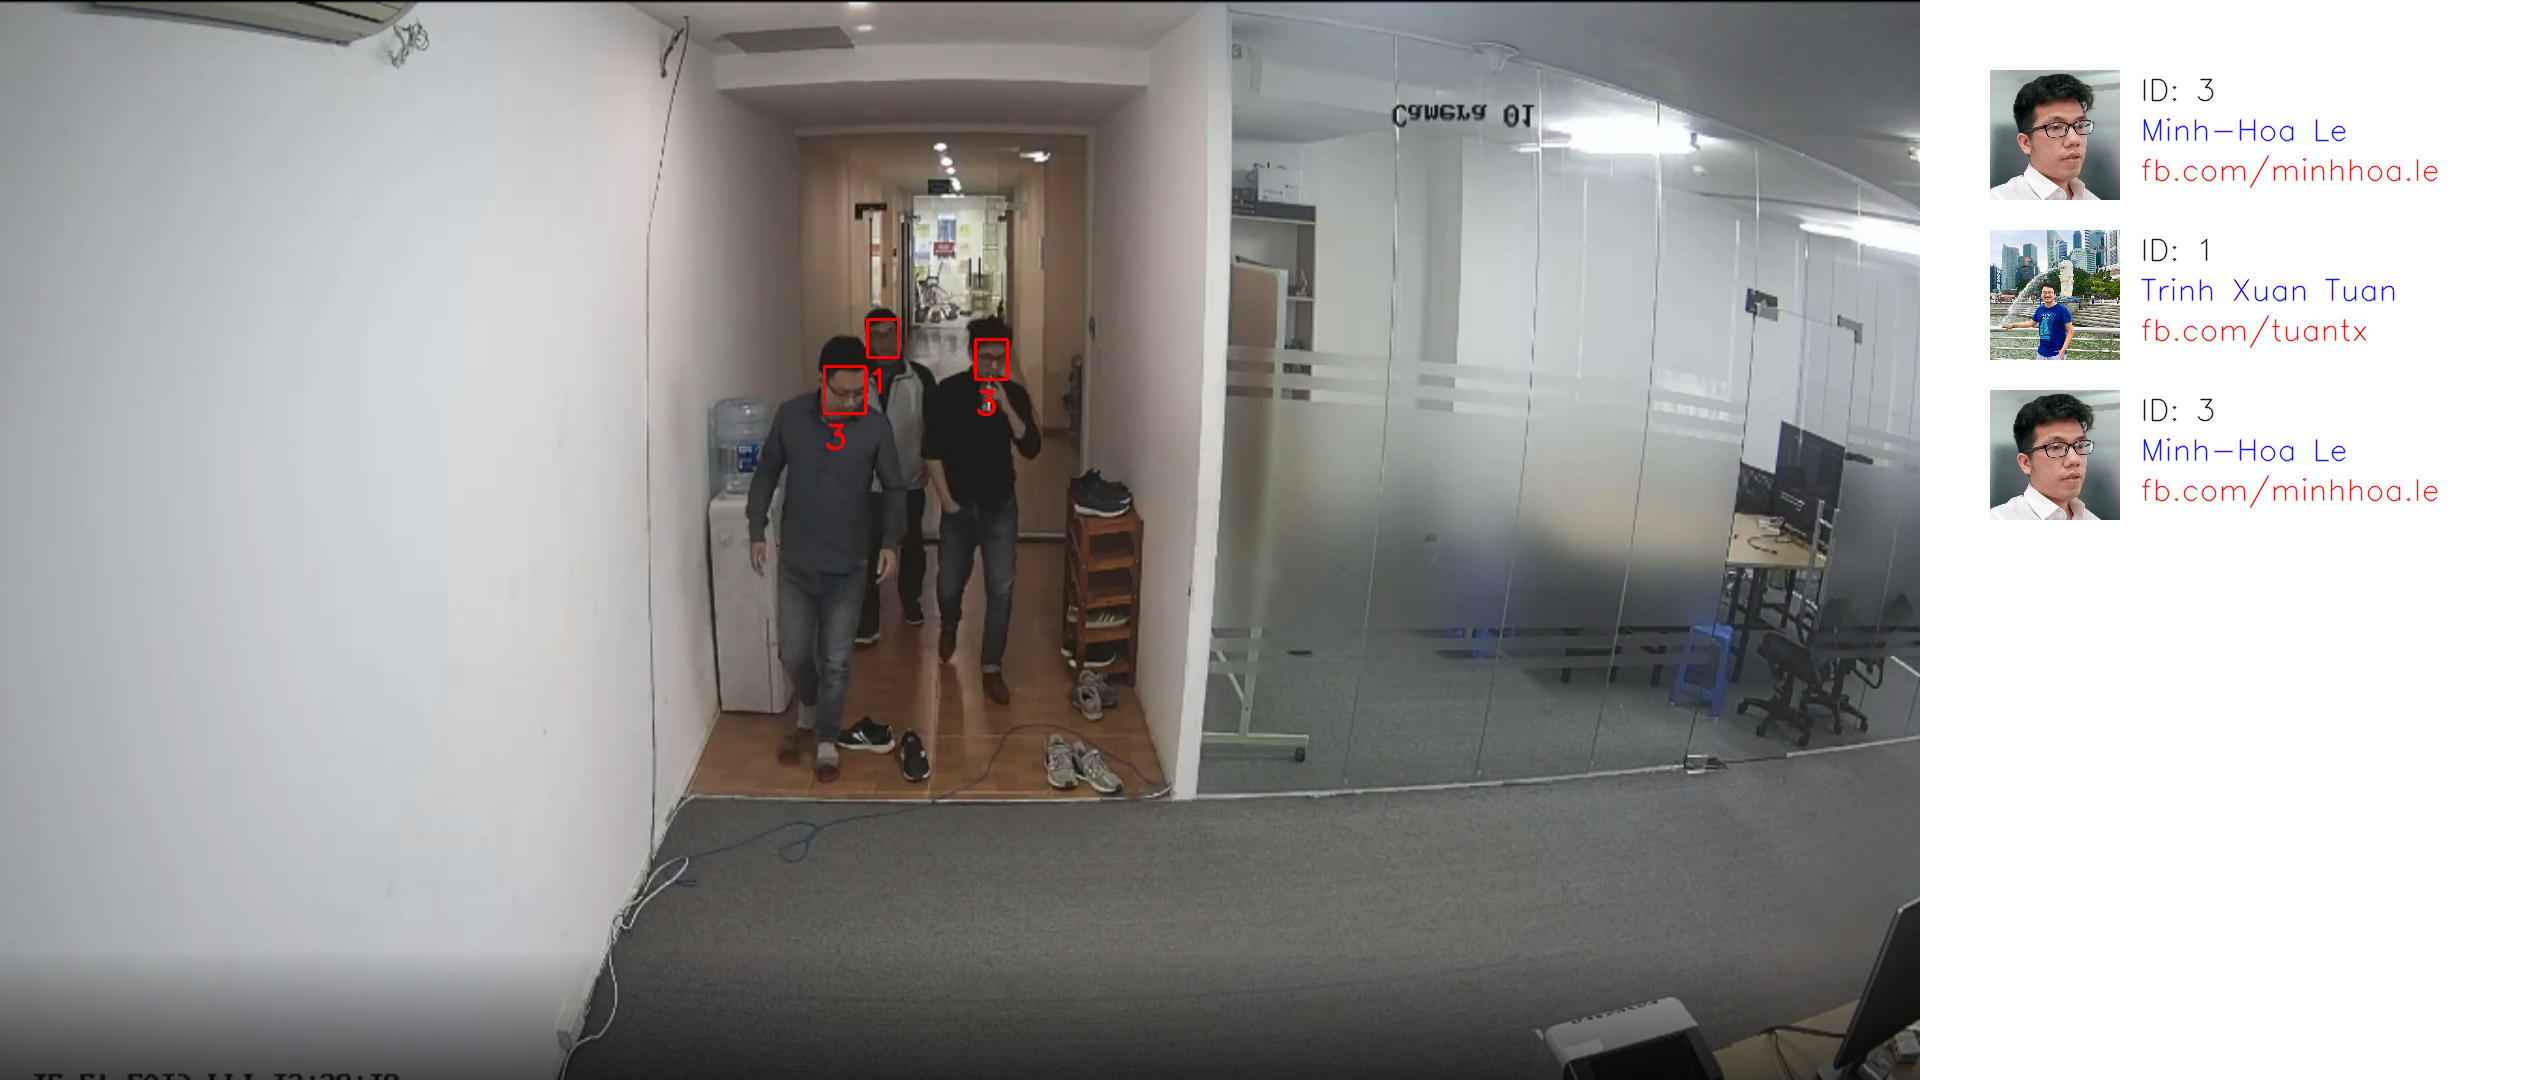

In [3]:
img_1 = cv2.imread('../data/debug/tmp.png')
img = visualize_face_recognition(
        model, img_1, output_size=(1920, 1080), bbox_thresh=0.1,
        dist_thresh=1.26, metadata=metadata, viz_info=True)
display(Image.fromarray(img[:, :, ::-1]))